In [103]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import argparse, sys, numpy as np, scipy as sc, warnings
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/tools/')
import flatsky, tools, misc
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [105]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [106]:
#params
paramfile = 'params.ini'
freqarr = [90, 150, 220, 270]
beamarr= [2.3, 1.5, 1.0, 0.8]
noisearr = [2.0, 2.0, 6.9, 16.7]
elkneearr = [2154., 4364., 7334., 7308.]
alphakneearr = [3.5, 3.5, 3.5, 3.5]
'''
freqarr = [90, 150, 220]#, 270]
beamarr= [3.5,2.0,1.4]#, 0.8]
noisearr = [1.0, 1.0, 1.0]
elkneearr = [-1, -1, -1, -1]
alphakneearr = [0, 0, 0, 0]
'''

'\nfreqarr = [90, 150, 220]#, 270]\nbeamarr= [3.5,2.0,1.4]#, 0.8]\nnoisearr = [1.0, 1.0, 1.0]\nelkneearr = [-1, -1, -1, -1]\nalphakneearr = [0, 0, 0, 0]\n'

In [107]:
# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])

In [108]:
#collect beam and noise into a dic
beam_noise_dic = {}
for (freq, beam, noise) in zip(freqarr, beamarr, noisearr):
    beam_noise_dic[freq] = [beam, noise]

In [109]:
#collect elknee and alpha into a dic
elknee_dic = {}
for (freq, elknee, alphaknee) in zip(freqarr, elkneearr, alphakneearr):
    elknee_dic[freq] = [elknee, alphaknee]

In [110]:
#get beam deconvolved noise nls
nl_dic = {}
for freq in freqarr:
    beamval, noiseval = beam_noise_dic[freq]
    nl = misc.get_nl(noiseval, el, beamval, elknee_t=elknee_dic[freq][0], alpha_knee=elknee_dic[freq][1])
    nl[el<=param_dict['lmin']] = 0.
    nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
    nl_dic[freq] = nl

In [111]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []
el, cl_dic = ilc.get_covariance_dic(param_dict, freqarr, nl_dic = nl_dic, ignore_fg = ignore_fg)
print(cl_dic.keys())

dict_keys([(90, 90), (90, 150), (90, 220), (90, 270), (150, 90), (150, 150), (150, 220), (150, 270), (220, 90), (220, 150), (220, 220), (220, 270), (270, 90), (270, 150), (270, 220), (270, 270)])


In [112]:
#get the residual power now
cl_residual = ilc.residual_power(param_dict, freqarr, el, cl_dic, final_comp = 'CMB')#, freqcalib_fac = None)
print(cl_residual)

[0.00000000e+00 1.44580095e+05 1.27792003e+04 ... 2.30634929e-05
 2.30697234e-05 2.30759570e-05]


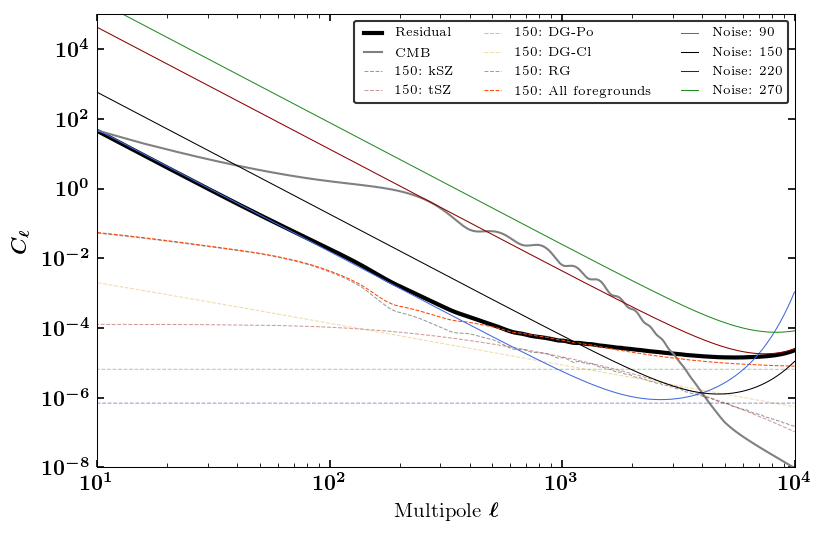

In [113]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']
el_, cl_cmb = fg.get_foreground_power_george_2015('CMB', freq1 = freq0, lmax = lmax)
foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG']

clf(); 
ax = subplot(111, xscale = 'log', yscale = 'log')
plot(el, cl_residual, 'black', lw = 2., label = r'Residual')
plot(el, cl_cmb, 'gray', lw = 1., label = r'CMB')
cl_fg = np.zeros(len(cl_cmb))
for curr_fg in foregrounds_to_plot:
    el_, cl_curr_fg = fg.get_foreground_power_george_2015(curr_fg, freq1 = freq0, lmax = lmax)
    plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
    cl_fg += cl_curr_fg
plot(el, cl_fg, lw = 0.5, ls = '--', label = r'150: All foregrounds', alpha = 1.)
for freq in freqarr:
    plot(el, nl_dic[freq], lw = 0.5, ls = '-', label = r'Noise: %s' %(freq))#, alpha = 0.5)
legend(loc=1, fancybox=1, ncol = 3, fontsize = 6);
xlim(10,1e4);ylim(1e-8,1e5);
xlabel(r'Multipole $\ell$')
ylabel(r'$C_{\ell}$')
show()